In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset, DataLoader
import numpy as np
from tqdm import tqdm
from diffusers import DDPMScheduler
import lpips
from pytorch_msssim import ssim
from trainning.train import train_model 
from diffusers.models.unet_2d_condition import UNet2DConditionModel
from trainning.fusion_dataset import FusionDataset

import matplotlib.pyplot as plt

c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class CNNBranch(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),  # [B,64,H/2,W/2]
            nn.ReLU(),
            nn.Conv2d(64, feature_dim, kernel_size=3, stride=2, padding=1),  # [B,F,H/4,W/4]
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)


class TransformerBranch(nn.Module):
    def __init__(self, feature_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim, nhead=num_heads, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)  # [B,HW,C]
        x = self.transformer(x)
        x = x.transpose(1, 2).view(B, C, H, W)
        return x

class HybridEncoder(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128):
        super().__init__()
        self.cnn1 = CNNBranch(in_channels, feature_dim)
        self.cnn2 = CNNBranch(in_channels, feature_dim)
        self.transformer = TransformerBranch(feature_dim=feature_dim)

    def forward(self, img1, img2):
        feat1 = self.cnn1(img1)
        feat2 = self.cnn2(img2)
        fused = (feat1 + feat2) / 2  # simple average fusion (can be replaced with attention)
        global_context = self.transformer(fused)
        return global_context
    
class FusionDiffusionModel(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128, image_size=32):
        super().__init__()
        self.encoder = HybridEncoder(in_channels=in_channels, feature_dim=feature_dim)

        # Diffusion UNet as pretrained decoder
        self.unet = UNet2DConditionModel(
            sample_size=image_size,      # 32 for CIFAR
            in_channels=in_channels,     # noisy image channels
            out_channels=in_channels,    # predict noise
            layers_per_block=2,
            block_out_channels=(128, 128, 256),
            down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
        )

    def forward(self, img1, img2, noisy_img, timesteps):
        cond = self.encoder(img1, img2)          # [B, C, H, W]
        cond = cond.mean(dim=[2, 3])             # [B, C]
        cond = cond.unsqueeze(1)                 # [B, 1, C] → sequence for attention
        pred = self.unet(noisy_img, timesteps, encoder_hidden_states=cond)
        return pred.sample


In [ ]:
class FusionLoss(nn.Module):
    def __init__(self, device="cuda", alpha=1.0, beta=0.5, gamma=0.1):
        super().__init__()
        self.mse = nn.MSELoss()
        self.perceptual = lpips.LPIPS(net='vgg').to(device)
        self.alpha, self.beta, self.gamma = alpha, beta, gamma

    def forward(self, pred, target, clean_target):
        mse_loss = self.mse(pred, target)
        ssim_loss = 1 - ssim(clean_target, target, data_range=1.0, size_average=True)
        perc_loss = self.perceptual(clean_target, target).mean()

        total_loss = self.alpha*mse_loss + self.beta*ssim_loss + self.gamma*perc_loss
        return total_loss, mse_loss.item(), ssim_loss.item(), perc_loss.item()


# ----------------------------
# Training Loop (Diffusion-style)
# ----------------------------
def train_fusion_diffusion(model, dataloader, num_epochs=10, lr=1e-4, device="cuda"):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = DDPMScheduler(num_train_timesteps=1000)  # noise schedule
    criterion = FusionLoss(device=device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_mse, epoch_ssim, epoch_perc = 0, 0, 0, 0

        for img, txt_embeddings, target in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            img, txt_embeddings, target = img.to(device), txt_embeddings.to(device), target.to(device)

            # Sample random timestep
            bsz = target.shape[0]
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (bsz,), device=device).long()

            # Add noise according to schedule
            noise = torch.randn_like(target)
            noisy_target = scheduler.add_noise(target, noise, timesteps)

            # Forward pass through fusion-diffusion pipeline
            pred_noise = model(img, txt_embeddings, noisy_target, timesteps)

            # Loss: predict the original noise
            loss, mse_val, ssim_val, perc_val = criterion(pred_noise, noise, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_mse += mse_val
            epoch_ssim += ssim_val
            epoch_perc += perc_val

        n = len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {epoch_loss/n:.4f} | "
              f"MSE: {epoch_mse/n:.4f} | "
              f"SSIM: {epoch_ssim/n:.4f} | "
              f"Perceptual: {epoch_perc/n:.4f}")


In [ ]:
transform = T.Compose([
    T.Resize((32, 32)), 
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])
# Full CIFAR10 train set
base_cifar = CIFAR10(root="./data", train=True, download=True, transform=transform)

# Pick 5k random indices
subset_indices = np.random.choice(len(base_cifar), 5000, replace=False)

# Wrap into Subset
small_cifar = Subset(base_cifar, subset_indices)

fusion_dataset = FusionDataset(small_cifar, modality="pair", transform=None)
fusion_loader = DataLoader(fusion_dataset, batch_size=64, shuffle=True, num_workers=7, pin_memory=True)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = FusionDiffusionModel(in_channels=3, feature_dim=128, image_size=32)

In [ ]:
train_model(model, dataloader=fusion_loader, num_epochs=10, lr=1e-4, device=device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It 

Loading model from: c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\lpips\weights\v0.1\vgg.pth


Epoch 1/10:   0%|          | 0/79 [00:00<?, ?it/s]c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/10: 100%|██████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch [1/10] Loss: 0.7323 | MSE: 0.1592 | SSIM: 0.9965 | Perceptual: 0.7485


Epoch 2/10: 100%|██████████| 79/79 [00:51<00:00,  1.53it/s]


Epoch [2/10] Loss: 0.6395 | MSE: 0.0664 | SSIM: 0.9964 | Perceptual: 0.7493


Epoch 3/10: 100%|██████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch [3/10] Loss: 0.6270 | MSE: 0.0538 | SSIM: 0.9965 | Perceptual: 0.7495


Epoch 4/10: 100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


Epoch [4/10] Loss: 0.6248 | MSE: 0.0517 | SSIM: 0.9963 | Perceptual: 0.7493


Epoch 5/10: 100%|██████████| 79/79 [00:58<00:00,  1.36it/s]


Epoch [5/10] Loss: 0.6243 | MSE: 0.0511 | SSIM: 0.9965 | Perceptual: 0.7497


Epoch 6/10: 100%|██████████| 79/79 [01:08<00:00,  1.15it/s]


Epoch [6/10] Loss: 0.6180 | MSE: 0.0449 | SSIM: 0.9964 | Perceptual: 0.7494


Epoch 7/10: 100%|██████████| 79/79 [01:06<00:00,  1.20it/s]


Epoch [7/10] Loss: 0.6181 | MSE: 0.0449 | SSIM: 0.9965 | Perceptual: 0.7494


Epoch 8/10: 100%|██████████| 79/79 [00:55<00:00,  1.42it/s]


Epoch [8/10] Loss: 0.6146 | MSE: 0.0414 | SSIM: 0.9965 | Perceptual: 0.7494


Epoch 9/10: 100%|██████████| 79/79 [00:55<00:00,  1.43it/s]


Epoch [9/10] Loss: 0.6185 | MSE: 0.0453 | SSIM: 0.9965 | Perceptual: 0.7494


Epoch 10/10: 100%|██████████| 79/79 [00:55<00:00,  1.43it/s]

Epoch [10/10] Loss: 0.6151 | MSE: 0.0419 | SSIM: 0.9965 | Perceptual: 0.7492


In [ ]:
def show_samples(model, dataloader, device="cuda", num_samples=5, num_inference_steps=50):
    model.eval()
    img1, img2, target = next(iter(dataloader))
    img1, img2, target = img1.to(device), img2.to(device), target.to(device)

    # Create a DDPM scheduler for inference
    scheduler = DDPMScheduler(num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Start from random Gaussian noise
    noisy = torch.randn_like(target)

    # Run full denoising loop
    for t in scheduler.timesteps:
        with torch.no_grad():
            noise_pred = model(img1, img2, noisy, t)
        noisy = scheduler.step(noise_pred, t, noisy).prev_sample  # denoise

    pred = noisy  # final denoised fused image

    # Denormalize for visualization
    def denorm(x):
        return (x.clamp(-1,1) + 1) / 2

    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3*num_samples))
    for i in range(num_samples):
        axes[i,0].imshow(denorm(img1[i]).permute(1,2,0).cpu())
        axes[i,0].set_title("Input 1")
        axes[i,1].imshow(denorm(img2[i]).permute(1,2,0).cpu())
        axes[i,1].set_title("Input 2")
        axes[i,2].imshow(denorm(target[i]).permute(1,2,0).cpu())
        axes[i,2].set_title("Target")
        axes[i,3].imshow(denorm(pred[i]).permute(1,2,0).cpu())
        axes[i,3].set_title("Prediction (Generated)")
        for ax in axes[i]: ax.axis("off")
    plt.show()

Files already downloaded and verified


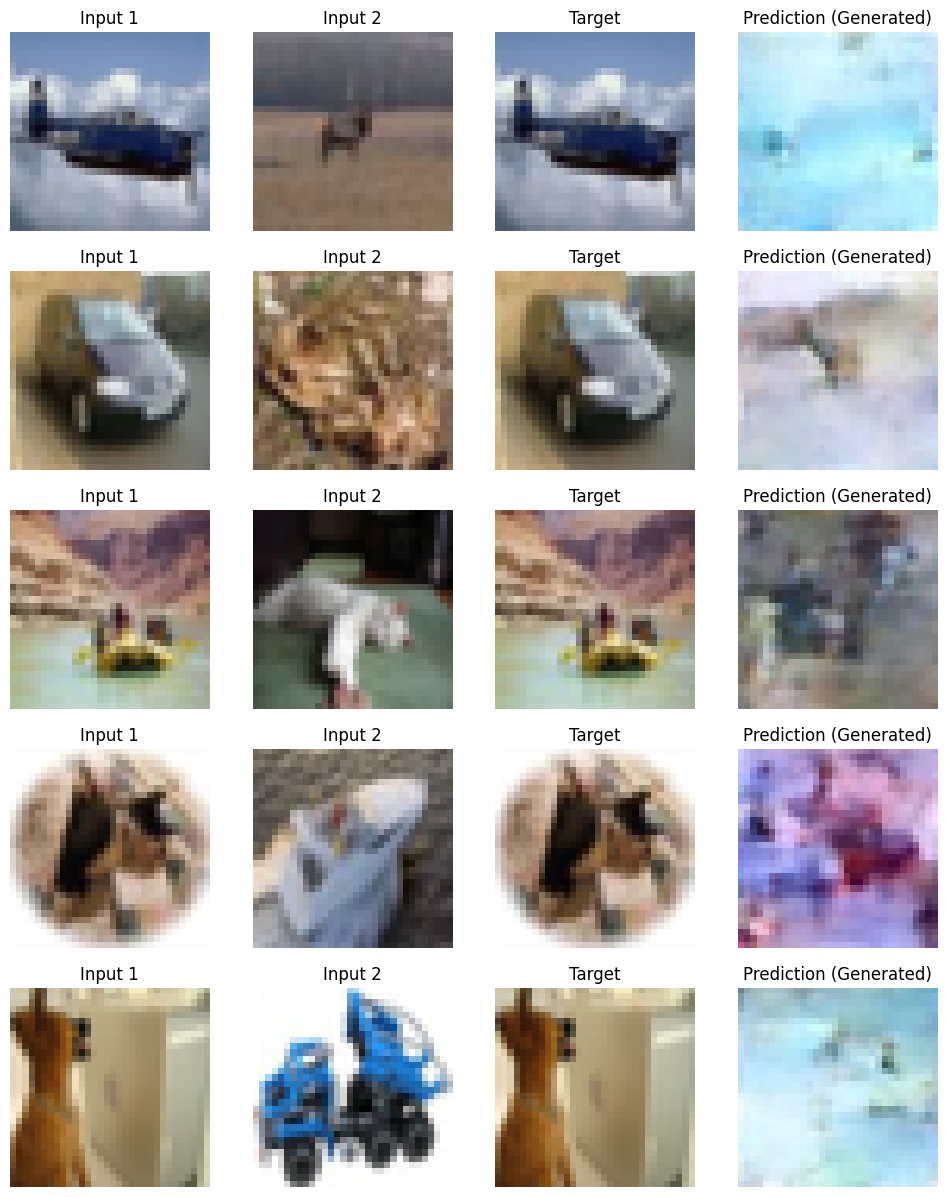

In [ ]:
test_cifar = CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dataset = FusionDataset(test_cifar, modality="pair")
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

show_samples(model, test_loader, device=device, num_samples=5, num_inference_steps=100)